## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
output_notebook()
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [2]:
from src.data.make_dataset import TCGA_LUAD
tgca_luad = TCGA_LUAD()
# tgca_luad.gene_univariate_feature_selection(alpha=0.01)
print len(tgca_luad.mirna_list)
print len(tgca_luad.gene_symbols)

Index([u'patient_barcode', u'pathologic_stage', u'histological_type',
       u'hsa-let-7a-1', u'hsa-let-7a-2', u'hsa-let-7a-3', u'hsa-let-7b',
       u'hsa-let-7c', u'hsa-let-7d', u'hsa-let-7e',
       ...
       u'hsa-mir-941-5', u'hsa-mir-942', u'hsa-mir-943', u'hsa-mir-944',
       u'hsa-mir-95', u'hsa-mir-9500', u'hsa-mir-96', u'hsa-mir-98',
       u'hsa-mir-99a', u'hsa-mir-99b'],
      dtype='object', length=1884)
Acinar                 18
Bronchioloalveolar     24
Clear Cell              2
Colloid                10
Micropapillary          3
Mixed Subtype         107
Mucinous                2
NOS                   320
Papillary              23
Signet Ring             1
Solid                   5
Name: histological_type, dtype: int64
mirna_tumor (506, 1884)
mirna_normal (46, 1884)
gene_tumor (515, 20487)
gene_normal (59, 20487)
1881
20502


## Build all miRNA-gene associations

In [3]:
all_mirna_gene_assc = []
for m in tgca_luad.mirna_list:
    for t in tgca_luad.gene_symbols:
        all_mirna_gene_assc.append((m, t))
print len(all_mirna_gene_assc)
all_mirna_gene_assc = pandas.DataFrame(all_mirna_gene_assc, columns=["MiRBase ID", "Gene Symbol"])
print all_mirna_gene_assc.shape

38564262
(38564262, 2)


## Loading TargetScan database for predicted miRNA-targets interactions

In [3]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(tgca_luad.mirna_list) & targetScan_df['Gene Symbol'].isin(tgca_luad.gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Loading miRanda database for predicted miRNA-targets interactions

In [4]:
miRanda_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/miRanda_hg19_predictions_S_C_aug2010.txt'), delimiter='\t')
miRanda_df = miRanda_df[['mirna_name',  'gene_symbol']]

miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.lower()
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("*", "")
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("-3p.*|-5p.*", "")
print miRanda_df.shape

miRanda_df.columns = ["MiRBase ID", "Gene Symbol"]
miRanda_df = miRanda_df[miRanda_df['MiRBase ID'].isin(tgca_luad.mirna_list) & miRanda_df['Gene Symbol'].isin(tgca_luad.gene_symbols)].dropna().drop_duplicates()
print miRanda_df.shape
putative_assocs = pandas.concat([targetScan_df, miRanda_df]).dropna().drop_duplicates()
print putative_assocs.shape

(1097064, 2)
(544648, 2)
(640757, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs
## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target

In [141]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import warnings
warnings.filterwarnings('ignore')

network_subtype = miRNATargetNet(miRNAs=tgca_luad.mirna_list, targets=tgca_luad.gene_symbols)
tags = ['Acinar-Bronchioloalveolar', 'Papillary-Bronchioloalveolar', 'Acinar-Papillary']
print network_subtype.fit(tag="Acinar-Bronchioloalveolar", p_threshold=0.001, n_jobs=7,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', histological_types=['Acinar'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', histological_types=['Acinar'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', histological_types=['Bronchioloalveolar'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', histological_types=['Bronchioloalveolar'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=all_mirna_gene_assc)

print network_subtype.fit(tag="Papillary-Bronchioloalveolar", p_threshold=0.001, n_jobs=7,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', histological_types=['Papillary'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', histological_types=['Papillary'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', histological_types=['Bronchioloalveolar'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', histological_types=['Bronchioloalveolar'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=all_mirna_gene_assc)

print network_subtype.fit(tag="Acinar-Papillary", p_threshold=0.001, n_jobs=7,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', histological_types=['Acinar'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', histological_types=['Acinar'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', histological_types=['Papillary'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', histological_types=['Papillary'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=all_mirna_gene_assc)

n_A 18
n_B 24
2773
n_A 23
n_B 24
3764
n_A 18
n_B 23
3824


In [4]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import warnings
warnings.filterwarnings('ignore')

network = miRNATargetNet(miRNAs=tgca_luad.mirna_list, targets=tgca_luad.gene_symbols)
tags = ["normal-StgI", "StgI-StgII", "StgII-StgIII", "StgIII-StgIV"]
print network.fit(tag="normal-StgI", p_threshold=0.001, n_jobs=8,
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='normal',
                                           normal_matched=True, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='normal',
                                          normal_matched=True, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor',
                                           normal_matched=True, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor',
                                          normal_matched=True, mirna_gene_matched=True)[0],
            putative_assocs=all_mirna_gene_assc)

# print network.fit(tag="StgI-StgII", p_threshold=0.001, n_jobs=8,
#             miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
#                                            normal_matched=False, mirna_gene_matched=True)[0],
#             gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
#                                           normal_matched=False, mirna_gene_matched=True)[0],
#             miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
#                                            normal_matched=False, mirna_gene_matched=True)[0],
#             gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
#                                           normal_matched=False, mirna_gene_matched=True)[0],
#             putative_assocs=all_mirna_gene_assc)

# print network.fit(tag="StgII-StgIII", p_threshold=0.001, n_jobs=8,
#             miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
#                                            normal_matched=False, mirna_gene_matched=True)[0],
#             gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
#                                           normal_matched=False, mirna_gene_matched=True)[0],
#             miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
#                                            normal_matched=False, mirna_gene_matched=True)[0],
#             gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
#                                           normal_matched=False, mirna_gene_matched=True)[0],
#             putative_assocs=all_mirna_gene_assc)

# print network.fit(tag="StgIII-StgIV", p_threshold=0.001, n_jobs=8,
#             miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
#                                            normal_matched=False, mirna_gene_matched=True)[0],
#             gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
#                                           normal_matched=False, mirna_gene_matched=True)[0],
#             miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage IV'],
#                                            normal_matched=False, mirna_gene_matched=True)[0],
#             gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage IV'],
#                                           normal_matched=False, mirna_gene_matched=True)[0],
#             putative_assocs=all_mirna_gene_assc)

n_A 19
n_B 19
268472


In [43]:
network.build_miRNA_features(tags=["normal-StgI"])

miRNAs_in_MTDN 1076
genes dysregulated in  normal-StgI 18072


In [145]:
network_subtype.build_miRNA_features(tags=['Acinar-Bronchioloalveolar', 'Papillary-Bronchioloalveolar', 'Acinar-Papillary'])

miRNAs_in_MTDN 239
genes dysregulated in  Acinar-Bronchioloalveolar 882
genes dysregulated in  Papillary-Bronchioloalveolar 1563
genes dysregulated in  Acinar-Papillary 2192


## Bipartite Graph Analysis

In [34]:
import networkx as nx
import copy

g = copy.deepcopy(network.B.to_undirected())
g.remove_nodes_from(nx.isolates(g))

miRNAs_nodes = set(n for n, d in g.nodes(data=True) if d['bipartite'] == 0)
targets_nodes = set(g) - miRNAs_nodes
print 'mirnas', len(miRNAs_nodes)
print 'targets', len(targets_nodes)
print 'edges',len(g.edges())

for m_i in miRNAs_nodes:
    for m_j in miRNAs_nodes:
        if (m_i is not m_j) and not (g.has_edge(m_i, m_j)):
            common_neighbors = sorted(nx.common_neighbors(g, m_i, m_j))
            if len(common_neighbors) > 0:
                m_i_degree = g.degree(m_i)
                m_j_degree = g.degree(m_j)
                
                weight = 0.0
                for gene in common_neighbors:
                    gene_degree = g.degree(gene)
                    weight += 1.0/gene_degree * min(float(g.number_of_edges(m_i, gene)), 
                                  float(g.number_of_edges(m_j, gene)))
                    
                weight = min(weight/m_i_degree, weight/m_j_degree)*10+1
                if weight > 1.1:
                    g.add_edge(u=m_i, v=m_j, weight=weight)

# miRNA_nodes_degrees = nx.bipartite.degrees(g, miRNAs_nodes)[1]
g.remove_nodes_from(targets_nodes)
g.remove_nodes_from(nx.isolates(g))
layout = nx.spring_layout(g, weight='weight',
                          k=5.1/np.sqrt(g.number_of_nodes()),
                          iterations=100)

print len(set(g))
print len(g.edges())

mirnas 1076
targets 18072
edges 268400
876
3788


In [38]:
from bokeh.models import ColumnDataSource

nodes, nodes_coordinates = zip(*sorted(layout.items()))
nodes_xs, nodes_ys = list(zip(*nodes_coordinates))
nodes_source = ColumnDataSource(dict(x=nodes_xs, y=nodes_ys,
                                     name=[mirna[4:] for mirna in nodes]))

In [39]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.layouts import widgetbox
from bokeh.models import HoverTool, LabelSet
from bokeh.models import Toggle, BoxAnnotation, CustomJS

hover = HoverTool(tooltips=[('name', '@name')])
plot = figure(plot_width=800, plot_height=600,
              tools=['tap', hover, 'box_zoom', 'reset', 'pan'])
plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None

r_circles = plot.circle('x', 'y', source=nodes_source, size=5,
                        color='blue', level='overlay')
hover.renderers.append(r_circles)

In [40]:
def get_edges_specs(_network, _layout):
    d = {'xs': [], 'ys': [], 'alphas': [], 'name': []}
    weights = [data['weight'] for u, v, data in _network.edges(data=True)]
    max_weight = max(weights)
    min_weight = min(weights)
    calc_alpha = lambda h: 0.3 + 0.8*((h-min_weight) / (max_weight-min_weight))
#     print weights
    for u, v, data in _network.edges(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
        d['alphas'].append(calc_alpha(data['weight']))
        d['name'].append(u+'<=>'+v)
    return d

lines_source = ColumnDataSource(get_edges_specs(g, layout))

r_lines = plot.multi_line('xs', 'ys', line_width=1.5,
                          alpha='alphas', color='black',
                          source=lines_source)
# show(plot)

In [41]:
centrality =\
    nx.algorithms.centrality.betweenness_centrality(g)
# first element are nodes again
_, nodes_centrality = zip(*sorted(centrality.items()))
max_centrality = max(nodes_centrality)
nodes_source.add([7 + 10 * t / max_centrality
                  for t in nodes_centrality],
                 'centrality')

import community # python-louvain
partition = community.best_partition(g)
p_, nodes_community = zip(*sorted(partition.items()))
nodes_source.add(nodes_community, 'community')
community_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628', '#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
nodes_source.add([community_colors[t % len(community_colors)]
                  for t in nodes_community],
                 'community_color')

print np.bincount(partition.values()), len(np.unique(partition.values()))

[65 37 47 24 38 30 84 68 48 15 30  7 48 75 31 39 29 12  3 20 31 33  3 24  2
  2  2  3  4  2  2  2  4  2  2  2  2  2  2] 39


In [42]:
r_circles.glyph.size = 'centrality'
r_circles.glyph.fill_color = 'community_color'

proc_labels = LabelSet(x='x', y='y', text="name", 
                       text_font_size="8pt", text_color="navy",
                       source=nodes_source, text_align='center')

plot.add_layout(proc_labels)

code = '''\
if toggle.active
    labels.visible = true
    console.log 'enabling box'
else
    labels.visible = false
    console.log 'disabling box'
'''
callback = CustomJS.from_coffeescript(code=code, args={})
toggle = Toggle(label="Toggle miRNA label", button_type="success", callback=callback)
callback.args = {'toggle': toggle, 'labels': proc_labels}

show(plot)
show(toggle)

## Clustering Analysis

[967, 50, 27, 23, 9]
[928, 50, 39, 23, 19, 9, 8]
[877, 51, 39, 35, 23, 19, 15, 8, 7, 2]
[854, 51, 39, 35, 23, 23, 19, 14, 8, 7, 2, 1]
[854, 51, 39, 35, 21, 19, 14, 14, 8, 7, 5, 4, 2, 2, 1]
[854, 39, 35, 33, 21, 19, 18, 14, 12, 8, 7, 5, 4, 2, 2, 2, 1]
[797, 48, 36, 35, 33, 21, 19, 18, 14, 12, 9, 8, 7, 5, 4, 3, 2, 2, 2, 1]


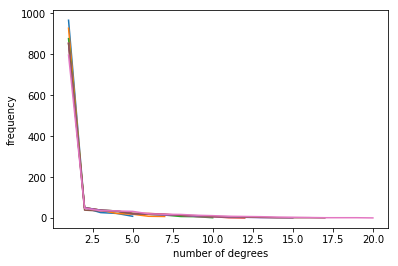

In [44]:
n_clusters = [5, 7, 10, 12, 15, 17, 20]

for n_cluster in n_clusters:
    bin_count = network.run_miRNA_clustering(n_cluster=n_cluster, linkage='complete')
    print sorted(bin_count, reverse=True)

In [45]:
network.run_miRNA_clustering(n_cluster=20, linkage='complete')

array([797,  12,  19,  35,   7,  18,   5,   4,  48,   2,  21,   1,  36,
         8,   2,  33,   2,   9,  14,   3])

## Get miRNA cluster assignment from partition

In [46]:
partition_mirnas_int = []
for group_no in np.unique(partition.values()):
    group = []
    for k, v in partition.iteritems():
        if v == group_no:
            group.append(tgca_luad.mirna_list.index(k))
    partition_mirnas_int.append(group)
partition_mirnas_int

[[458,
  78,
  373,
  374,
  1196,
  983,
  270,
  269,
  628,
  1291,
  652,
  1786,
  1548,
  1555,
  1656,
  1588,
  1352,
  1318,
  298,
  1603,
  1607,
  1609,
  404,
  287,
  623,
  1309,
  1644,
  381,
  1283,
  1020,
  714,
  1490,
  199,
  1836,
  1626,
  72,
  1320,
  1687,
  1674,
  1454,
  394,
  434,
  1147,
  245,
  1458,
  427,
  1723,
  572,
  967,
  1007,
  1710,
  1685,
  996,
  1772,
  518,
  104,
  603,
  601,
  774,
  1564,
  463,
  406,
  1171,
  960,
  958],
 [457,
  916,
  655,
  1148,
  867,
  217,
  308,
  218,
  1209,
  1076,
  1474,
  1118,
  1178,
  672,
  1214,
  1432,
  1056,
  291,
  1055,
  563,
  391,
  961,
  242,
  256,
  188,
  1379,
  869,
  868,
  182,
  358,
  998,
  980,
  327,
  819,
  1126,
  341,
  1256],
 [456,
  455,
  8,
  1140,
  1142,
  1138,
  271,
  356,
  911,
  626,
  1522,
  189,
  1146,
  495,
  624,
  89,
  1120,
  616,
  206,
  1624,
  433,
  1121,
  1506,
  1130,
  1122,
  1878,
  1156,
  1157,
  1155,
  1335,
  1475,
  1363,
  

## TarBase: Validated miRNA-target interactions

In [430]:
TarBase_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TarBase_Experiment_Valid_miRNA-Targets.csv'), delimiter='\t')
TarBase_df = TarBase_df[TarBase_df['species'] == 'Homo sapiens']
TarBase_df = TarBase_df[TarBase_df['tissue'].isin(['Lung Cancerous Tissues', 'Lung'])]
TarBase_df = TarBase_df[TarBase_df['category'] == 'Cancer/Malignant']
TarBase_df['mirna'] = TarBase_df['mirna'].str.lower()
TarBase_df['mirna'] = TarBase_df['mirna'].str.replace("-3p.*|-5p.*", "")
TarBase_df.drop_duplicates(inplace=True)

TarBase_df = TarBase_df[['geneName', 'mirna']]
TarBase_df.columns = ["Gene Symbol", "MiRBase ID"]
# TarBase_df

In [429]:
for row in TarBase_df.iterrows():
    if network.B.has_edge(row[1]['MiRBase ID'], row[1]['Gene Symbol']):
        print network.B.get_edge_data(row[1]['MiRBase ID'], row[1]['Gene Symbol'])

### Prepare samples for Classification task

In [55]:
from sklearn.model_selection import train_test_split

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=True, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
                              stage_label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})

print "X", X.shape
print "y", y.shape

X_multi, y_multi = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False, normalize=False,
                                          pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                                          stage_label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = \
    train_test_split(X_multi, y_multi, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y_multi)



print y.value_counts()
print y_multi.value_counts()

X (92, 1881)
y (92,)
1    46
0    46
Name: pathologic_stage, dtype: int64
1    277
2    121
3     84
0     46
4     24
Name: pathologic_stage, dtype: int64


## Create Classifiers

In [56]:
from src.models.group_lasso_spams import SPAMSClassifier
import spams

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 1000,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['lambda1'] = 0.5
param['lambda2'] = 0.5
param['lambda3'] = 0.5

X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])
X_multi_train = np.asfortranarray(X_multi_train, dtype=myfloat)
Y_multi_train = np.asfortranarray(Y_multi_train, dtype=myfloat)
Y_multi_train = np.reshape(Y_multi_train, [Y_multi_train.shape[0], 1])

# L1 Lasso
l1_lasso_param = param.copy()
l1_lasso_param['loss'] = 'weighted-logistic'
l1_lasso_param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=l1_lasso_param)

# Group Lasso L2
# group_l2_param = param.copy()
# group_l2_param['loss'] = 'weighted-logistic'
# group_l2_param['regul'] = 'group-lasso-l2'
# group_l2 = SPAMSClassifier()
# group_l2.fit(X_train, Y_train, groups=network.get_miRNA_cluster_assgn(), params=group_l2_param)

# Elastic Net
elastic_net_param = param.copy()
elastic_net_param['loss'] = 'weighted-logistic'
elastic_net_param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=elastic_net_param)

# # Sparse Group Lasso
# sparse_group_l2_param = param.copy()
# sparse_group_l2_param['loss'] = 'logistic'
# sparse_group_l2_param['regul'] = 'sparse-group-lasso-l2'
# sparse_group_l2_param['lambda1'] = 0.2
# sparse_group_l2 = SPAMSClassifier()
# sparse_group_l2.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(), params=sparse_group_l2_param)

# Multi Logistic
multi_task_l1l2_param = param.copy()
multi_task_l1l2_param['loss'] = 'multi-logistic'
multi_task_l1l2_param['regul'] = 'l1l2'
multi_task_l1l2_param['max_it'] = 200
multi_task_l1l2_param['lambda1'] = 0.5
multi_task_l1l2 = SPAMSClassifier()
multi_task_l1l2.fit(X_multi_train, Y_multi_train, groups=None, params=multi_task_l1l2_param)

FISTA Flat: {'loss': 'weighted-logistic', 'regul': 'l1', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'it0': 10, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5}


RuntimeError: matrix arg 1 must be a 2d double Fortran Array

## Logistic Regression with L1L2 & Overlapping Group LASSO regularizer

In [53]:
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.gl as gl
import parsimony.utils.start_vectors as start_vectors


X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
                              stage_label_mapping={'normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

A = gl.linear_operator_from_groups(X_train.shape[1],
                                   partition_mirnas_int,
                                   weights=[2*1./len(g) for g in partition_mirnas_int]
                                   )
beta = start_vectors.ZerosStartVector().get_vector(X_train.shape[1])

logistic_L1L2GL = estimators.LogisticRegressionL1L2GL(l1=4.5, l2=0.0, gl=5.5, A=A,
                                                      algorithm=algorithms.proximal.FISTA(),
                                                      class_weight='auto',
                                                      algorithm_params=dict(max_iter=1000),
                                                      mean=False)
logistic_L1L2GL.fit(X=X_train, y=Y_train, beta=beta)

print 'Non-zero:', len(logistic_L1L2GL.beta.nonzero()[0])

Non-zero: 484


## OneVsRestClassifier

In [109]:
from sklearn.multiclass import OneVsRestClassifier
from src.models.group_lasso_spams import LRSGLWrapper

lrsgl_one_vs_rest = OneVsRestClassifier(LRSGLWrapper(l1=2.5, l2=0.0, gl=5, A=A, max_iter=500))
lrsgl_one_vs_rest.fit(X=X_multi_train, y=Y_multi_train)

lr_one_vs_rest = OneVsRestClassifier(LRSGLWrapper(l1=2.5, l2=0.0, gl=0, max_iter=1000))
lr_one_vs_rest.fit(X=X_multi_train, y=Y_multi_train)

OneVsRestClassifier(estimator=LRSGLWrapper(A=None, gl=0, l1=2.5, l2=0.0, max_iter=1000),
          n_jobs=1)

## ROC Curve Cross Validation for LRSGL

(441, 1881) (441, 5)
(111, 1881) (111, 5)
ROC micro 0.787659280903
ROC macro 0.790185389153


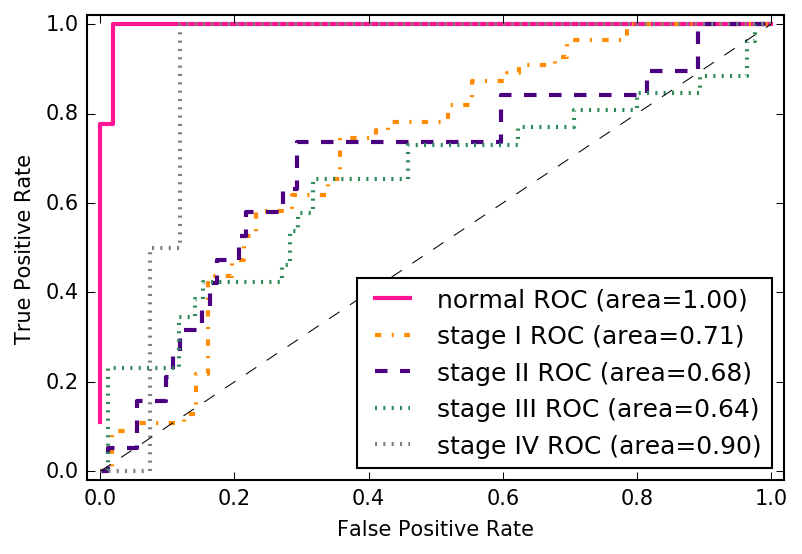

In [120]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                              stage_label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = 5
n_samples, n_features = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y,
                                                    random_state=0)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

def roc_auc_w_group():
    colors = cycle(['darkorange', 'indigo', 'seagreen', 'gray', 'red', 'cyan'])
    linestyles = cycle(['solid', 'dashed', 'dashdot', 'dotted'])
    lw = 2

    lr_ovr_with_sgl = OneVsRestClassifier(copy.deepcopy(LRSGLWrapper(l1=1.5, l2=0.0, gl=3.5, 
                                                       A=gl.linear_operator_from_groups(X_train.shape[1],
                                                           partition_mirnas_int), 
                                                       max_iter=1000)))
    lr_ovr_with_sgl.fit(X_train, y_train)

#     metrics.classification_report(y_test, lr_ovr_with_sgl.predict(X_test))

    y_score = lr_ovr_with_sgl.predict_proba(X_test)

    j = 0

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(dpi=150)
    print 'ROC micro', roc_auc["micro"]
    print 'ROC macro', roc_auc["macro"]

    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = cycle(['deeppink', 'darkorange', 'indigo', 'seagreen', 'gray', 'red', 'cyan'])
    linestyles = cycle(['solid', 'dashdot', '--', 'dotted', ':'])
    for i, color, linestyle in zip(range(n_classes), colors, linestyles):
        if i == 0:
            label = 'normal'
        elif i==1:
            label = 'stage I'
        elif i==2:
            label = 'stage II'
        elif i==3:
            label = 'stage III'
        elif i==4:
            label = 'stage IV'

        plt.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle=linestyle,
                 label='{0} ROC (area={1:0.2f})'
                 ''.format(label, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
roc_auc_w_group()

## Cross Validation for LR WITHOUT SGL

ROC micro 0.787659280903
ROC macro 0.790185389153


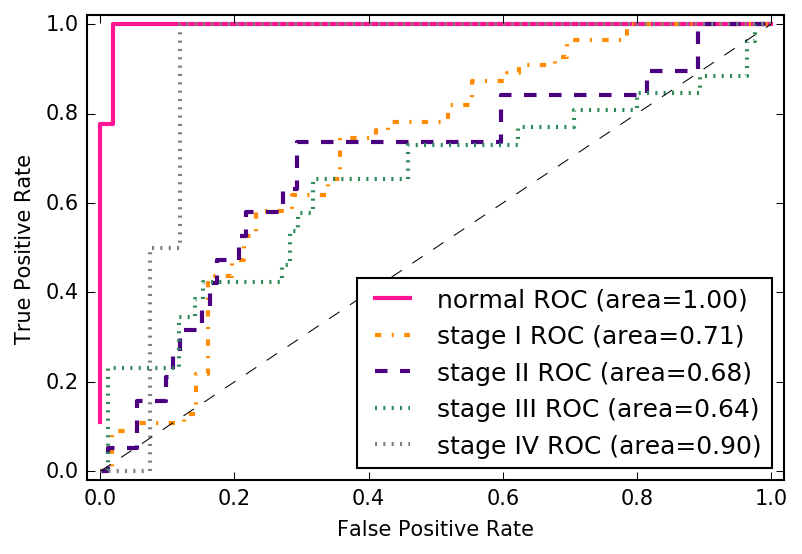

In [117]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier

# X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
#                               pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
#                               stage_label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})
# y = label_binarize(y, classes=[0, 1, 2, 3, 4])
# n_classes = y.shape[1]
# n_samples, n_features = X.shape
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y,
#                                                     random_state=0)

def roc_auc_wo_group():
    lw = 2

    lr_ovr_wo_sgl = OneVsRestClassifier(copy.deepcopy(LRSGLWrapper(l1=1.5, max_iter=1000)))
    y_score_wo = lr_ovr_wo_sgl.fit(X_train, y_train).predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_wo[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_wo.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(dpi=150)

    print 'ROC micro', roc_auc["micro"]
    print 'ROC macro', roc_auc["macro"]

    colors = cycle(['deeppink', 'darkorange', 'indigo', 'seagreen', 'gray', 'red', 'cyan'])
    linestyles = cycle(['solid', 'dashdot', '--', 'dotted', ':'])
    for i, color, linestyle in zip(range(n_classes), colors, linestyles):
        if i == 0:
            label = 'normal'
        elif i==1:
            label = 'stage I'
        elif i==2:
            label = 'stage II'
        elif i==3:
            label = 'stage III'
        elif i==4:
            label = 'stage IV'

        plt.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle=linestyle,
                 label='{0} ROC (area={1:0.2f})'
                 ''.format(label, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
roc_auc_wo_group()

## Parameter selection

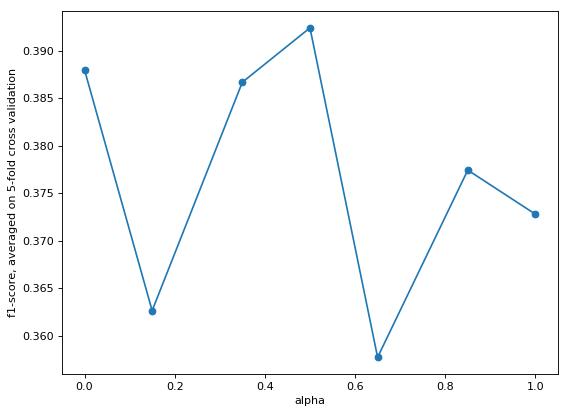

In [181]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(parameters['alpha'], l1_scores, 'o-')

plt.xlabel('alpha')
plt.ylabel('f1-score, averaged on 5-fold cross validation')
plt.title('')
# plt.ylim(0, 1)
plt.show()

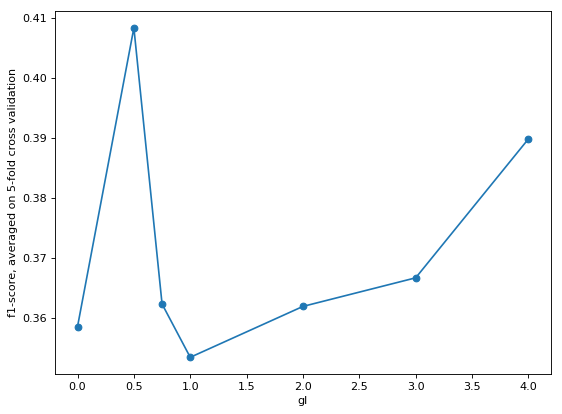

In [115]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(parameters['lambda'], gl_scores, 'o-')

plt.xlabel('gl')
plt.ylabel('f1-score, averaged on 5-fold cross validation')
plt.title('')
# plt.ylim(0,1)
plt.show()


## Classification Report

In [54]:
from sklearn import metrics

for model, name in [
                    (logistic_L1L2GL, 'Logistic L1L2GL'),
#                     (lr_ovr_wo_sgl, 'lr_ovr_wo_sgl'),
#                     (lr_ovr_with_sgl, 'lr_ovr_with_sgl'),
                    # (multi_task_l1l2, 'multi-task l1l2'),
                    # (multi_task_l1l2_cluster, 'multi_task_l1l2_cluster'),
                    # (group_l2, 'group_small'),
                    # (l1_lasso, 'l1_lasso'),
                    # (elastic_net, 'elastic_net'),
                    # (sparse_group_l2, 'sparse-group_small')
                    ]:
    print '\n', name
    if model is logistic_L1L2GL:
        predicted = logistic_L1L2GL.predict(X_train)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_train, predicted)
        predicted = logistic_L1L2GL.predict(X_test)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_test, predicted)
    elif model is multi_task_l1l2 or model is lr_ovr_wo_sgl or model is lr_ovr_with_sgl:
        print metrics.classification_report(Y_multi_train, model.predict(X_multi_train))
        print metrics.classification_report(Y_multi_test, model.predict(X_multi_test))
    # elif model is multi_task_l1l2_cluster:
    #     print metrics.classification_report(Y_multi_train, model.predict(X_multi_train.T[clustered_miRNA_indices].T))
        # print metrics.classification_report(Y_multi_test, model.predict(X_multi_test.T[clustered_miRNA_indices].T))
    else:
        print metrics.classification_report(Y_train, model.predict(X_train))
        print metrics.classification_report(Y_test, model.predict(X_test))


Logistic L1L2GL
             precision    recall  f1-score   support

         -1       0.14      1.00      0.25        37
          1       1.00      0.01      0.02       221

avg / total       0.88      0.15      0.05       258

             precision    recall  f1-score   support

         -1       0.15      1.00      0.25         9
          1       1.00      0.05      0.10        56

avg / total       0.88      0.18      0.12        65



## Loading HMDD database for experimentally validated NSCLC miRNA

In [15]:
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]
HMDD_lung_neoplasm_miRNAs = HMDD_df[1].unique()
print "HMDD_lung_neoplasm_miRNAs", HMDD_lung_neoplasm_miRNAs.shape

miRCancer_luad_miRNA_df = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))
miRCancer_luad_miRNAs = set(miRCancer_luad_miRNA_df['miRNA'].tolist())
print "miRCancer_luad_miRNAs", len(miRCancer_luad_miRNAs)


mir2disease_nsclc_miRNA_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/mir2Disease_miRNA-Disease.txt'), delimiter='\t', header=-1) 
mir2disease_nsclc_miRNA_df.columns = ['miRNA', 'disease', 'up_down', 'method', 'year', 'description'] 
mir2disease_nsclc_miRNA_df = mir2disease_nsclc_miRNA_df[(mir2disease_nsclc_miRNA_df['disease'] == 'non-small cell lung cancer (NSCLC)')]
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.lower()
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("*", "")
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("-3p.*|-5p.*", "")
mir2disease_nsclc_miRNA_df.drop_duplicates(inplace=True)
mir2disease_nsclc_miRNAs = mir2disease_nsclc_miRNA_df['miRNA'].unique()
print "mir2disease_nsclc_miRNAs", mir2disease_nsclc_miRNAs.shape

dbDEMC_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/dbDEMC.txt'), delimiter='\t')
dbDEMC_df = dbDEMC_df[dbDEMC_df['Cancer Type'] == 'lung cancer']
dbDEMC_df = dbDEMC_df[dbDEMC_df['Cancer Subtype'] == 'lung adenocarcinoma']
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.lower()
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.replace("*", "")
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.replace("-3p.*|-5p.*", "")
dbDEMC_luad_miRNAs = dbDEMC_df['miRNA ID'].unique()
print 'dbDEMC_luad_miRNAs', len(dbDEMC_df['miRNA ID'].unique())

validating_miRNAs = dbDEMC_luad_miRNAs

HMDD_lung_neoplasm_miRNAs (157,)
miRCancer_luad_miRNAs 27
mir2disease_nsclc_miRNAs (24,)
dbDEMC_luad_miRNAs 545


## Compare models by recall rate

In [61]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate, get_miRNA_names
from src.models.group_lasso_spams import LRSGLWrapper

models = []
for model, name in [
                    (lr_ovr_with_sgl, 'lr_ovr_with_sgl'),
                    (lr_ovr_wo_sgl, 'lr_ovr_wo_sgl')
                    # (logistic_L1L2GL, 'Logistic L1L2GL'),
                    # (multi_task_l1l2, 'multi-task l1l2'),
                    # (multi_task_l1l2_cluster, 'multi_task_l1l2_cluster'),
                    # (group_l2, 'group_small'),
                    # (l1_lasso, 'l1_lasso'),
                    # (elastic_net, 'elastic_net'),
                    # (sparse_group_l2, 'sparse-group_small')
                    ]:
    if model is logistic_L1L2GL:
        models.append([name,
                   len(model.beta.nonzero()[0]),
                   recall_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:275], tgca_luad.mirna_list),
                               validated_miRNAs=validating_miRNAs),
                    (lr_ovr_with_sgl, 'lr_ovr_with_sgl'),
                    (lr_ovr_wo_sgl, 'lr_ovr_wo_sgl')
                    # (logistic_L1L2GL, 'Logistic L1L2GL'),
                    # (multi_task_l1l2, 'multi-task l1l2'),
                    # (multi_task_l1l2_cluster, 'multi_task_l1l2_cluster'),
                    # (group_l2, 'group_small'),
                    # (l1_lasso, 'l1_lasso'),
                    # (elastic_net, 'elastic_net'),
                    # (sparse_group_l2, 'sparse-group_small')
                    
                   precision_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:275], tgca_luad.mirna_list),
                                  validated_miRNAs=validating_miRNAs) ])
    elif model is lr_ovr_with_sgl:
        models.append([name,
                   LRSGLWrapper.get_selected_miRNAs(lr_ovr_with_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=LRSGLWrapper.get_selected_miRNAs(lr_ovr_with_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=LRSGLWrapper.get_selected_miRNAs(lr_ovr_with_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=validating_miRNAs) ])
    elif model is lr_ovr_wo_sgl:
        models.append([name,
                   LRSGLWrapper.get_selected_miRNAs(lr_ovr_wo_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=LRSGLWrapper.get_selected_miRNAs(lr_ovr_wo_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=LRSGLWrapper.get_selected_miRNAs(lr_ovr_wo_sgl.estimators_, tgca_luad.mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=validating_miRNAs) ])
    else:
        models.append([name,
                   model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=validating_miRNAs) ])

pandas.DataFrame(models, columns=['method', 'no_selected', 'recall_rate', 'precision_rate']).sort_values(by='recall_rate', ascending=False)
# (group_l2_large_groups, 'group_l2_large_groups'),
# (l1_lasso, 'l1_lasso'),
# (elastic_net, 'elastic_net'),
# (sparse_group_l2, 'sparse-group-lasso-l2'),
# (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')

SyntaxError: invalid syntax (<ipython-input-61-509c6bc3892d>, line 31)

## Check each candidate miRNA's if validated

In [38]:
candidate_miRNAs = multi_task_l1l2.get_selected_miRNAs(tgca_luad.mirna_list)
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in validating_miRNAs, axis=1)
# candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.head(20)

,miRNA,coef,validated
50,hsa-mir-148a,-0.000126,True
180,hsa-mir-451a,-0.000102,True
69,hsa-mir-182,-0.000089,True
160,hsa-mir-372,0.000086,False
27,hsa-mir-126,-0.000084,True
225,hsa-mir-582,0.000080,True
131,hsa-mir-30d,-0.000078,True
115,hsa-mir-25,-0.000078,True
92,hsa-mir-200a,-0.000078,True
44,hsa-mir-142,0.000076,True


In [157]:
candidate_miRNAs = pandas.DataFrame([(tgca_luad.mirna_list[m], logistic_L1L2GL.beta[m][0]) for m in logistic_L1L2GL.beta.nonzero()[0]])
candidate_miRNAs.columns = ['miRNA', 'coef']
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in validating_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.reindex(candidate_miRNAs.coef.abs().sort(inplace=False, ascending=False).index).head(20)

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


,miRNA,coef,validated,groups
87,hsa-mir-203a,0.000195,True,[]
64,hsa-mir-182,0.000082,True,[]
48,hsa-mir-148a,0.000081,True,[]
15,hsa-mir-103a-2,-0.000070,True,[]
14,hsa-mir-103a-1,-0.000069,False,[]
90,hsa-mir-21,0.000065,True,[]
115,hsa-mir-29c,0.000061,True,[]
179,hsa-mir-99b,-0.000054,True,[]
122,hsa-mir-30e,0.000053,True,[]
65,hsa-mir-183,0.000050,True,[]


### Recall & Precision of Top Ranked miRNAs

In [57]:
top_k_s = [10, 30, 60, 90, 120, 160, 200, 250]

candidate_miRNAs = pandas.DataFrame()
candidate_miRNAs['miRNAs'] = tgca_luad.mirna_list
candidate_miRNAs['coef'] = logistic_L1L2GL.beta

recall_rates = []
precision_rates = []
for top_k in top_k_s:
    top_k_miRNAs = candidate_miRNAs.reindex(candidate_miRNAs.coef.abs().sort(inplace=False, ascending=False).index).head(top_k)['miRNAs'].tolist()

    recall_rates.append(recall_rate(candidate_miRNAs=top_k_miRNAs, validated_miRNAs=dbDEMC_luad_miRNAs))
    precision_rates.append(precision_rate(candidate_miRNAs=top_k_miRNAs, validated_miRNAs=dbDEMC_luad_miRNAs))
    
# plt.figure()
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
width = 0.3
font_size = 14

rects1 = ax.bar(range(len(top_k_s)), precision_rates, width, color='black')
ax.set_ylabel('Precision rate of known LUAD miRNAs (%)', fontsize=font_size)
ax.set_yticks([i/10. for i in range(10)])
# ax.set_ylim((0, 1))

ax2 = ax.twinx()
rects2 = ax2.bar([width+k for k in range(len(top_k_s))], recall_rates, width, color='gray')
# ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Recall rate of known LUAD miRNAs (%)', fontsize=font_size)

ax.legend((rects1[0], rects2[0]), ('Precision Rate', 'Recall rate'), loc=(0.5, 0.88), fontsize=11)
ax.set_xlabel('# of top-ranked miRNAs', fontsize=font_size)
ax.set_xticks([width/2+k for k in range(len(top_k_s))])
ax.set_xticklabels(['Top '+str(top_k) for top_k in top_k_s], fontsize=10)
plt.show()

AttributeError: 'LogisticRegressionL1L2GL' object has no attribute 'beta'

## Precision for each miRNA groups

In [20]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate, get_miRNA_names
# network_subtype.run_miRNA_clustering(n_cluster=17)
miRNA_groups_precision = []
miRNA_groups_precision 
for cluster in partition_mirnas_int:
#     print get_miRNA_names(cluster, tgca_luad.mirna_list) 
    miRNA_groups_precision.append((len(cluster), 
                                   get_miRNA_names(cluster, tgca_luad.mirna_list),
                                   precision_rate(candidate_miRNAs=get_miRNA_names(cluster, tgca_luad.mirna_list), 
                                                  validated_miRNAs=dbDEMC_luad_miRNAs),
                                   len(set(get_miRNA_names(cluster, tgca_luad.mirna_list)).intersection(
                                       get_miRNA_names(logistic_L1L2GL.beta.nonzero()[0], tgca_luad.mirna_list))),
                                   precision_rate(candidate_miRNAs=set(get_miRNA_names(cluster, tgca_luad.mirna_list)).intersection(
                                       get_miRNA_names(logistic_L1L2GL.beta.nonzero()[0], tgca_luad.mirna_list)), 
                                                  validated_miRNAs=dbDEMC_luad_miRNAs)
                                   ))

pandas.DataFrame(miRNA_groups_precision, columns=['Size of cluster', 'miRNA', 'precision to LUAD', '# selected in model', 'selected in model and in LUAD']).sort_values(by='precision to LUAD', ascending=False)

,Size of cluster,miRNA,precision to LUAD,# selected in model,selected in model and in LUAD
38,2,"(hsa-mir-23a, hsa-mir-23b)",1.000000,2,1.000000
36,2,"(hsa-let-7a-2, hsa-mir-497)",1.000000,1,1.000000
35,2,"(hsa-mir-24-1, hsa-mir-24-2)",1.000000,2,1.000000
25,2,"(hsa-mir-138-1, hsa-mir-639)",1.000000,0,NaN
3,24,"(hsa-mir-3191, hsa-mir-4638, hsa-mir-29c, hsa-...",0.666667,17,0.647059
20,31,"(hsa-mir-30a, hsa-mir-30e, hsa-mir-193a, hsa-m...",0.548387,10,1.000000
37,2,"(hsa-mir-103a-2, hsa-mir-103a-1)",0.500000,2,0.500000
24,2,"(hsa-mir-216a, hsa-mir-4724)",0.500000,0,NaN
26,2,"(hsa-mir-494, hsa-mir-376a-1)",0.500000,0,NaN
32,4,"(hsa-mir-370, hsa-mir-432, hsa-mir-433, hsa-mi...",0.500000,1,1.000000


In [155]:
len(set(network.miRNA_clusters_int[0]).intersection(set(network_subtype.miRNA_clusters_int[0])))

207